# GRAD CAM

## 下載圖片與資料

In [ ]:
!wget -O example.jpg 'https://www.burnaby.ca/sites/default/files/acquiadam/2021-06/Parks-Fraser-Foreshore.jpg'

--2023-03-22 03:19:32--  https://www.burnaby.ca/sites/default/files/acquiadam/2021-06/Parks-Fraser-Foreshore.jpg
Resolving www.burnaby.ca (www.burnaby.ca)... 104.18.26.33, 104.18.27.33, 2606:4700::6812:1a21, ...
Connecting to www.burnaby.ca (www.burnaby.ca)|104.18.26.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562035 (549K) [image/jpeg]
Saving to: ‘example.jpg’

example.jpg         100%[===================>] 548.86K   730KB/s    in 0.8s    

2023-03-22 03:19:35 (730 KB/s) - ‘example.jpg’ saved [562035/562035]



In [ ]:
!wget -O example.jpg 'https://www.thespruce.com/thmb/MPYiUaz2XM0KLieeiob0_TZo83s=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/feeding-your-chickens-or-laying-hens-3016556-hero-97593a72ef95449e9a68312a875e32cb.jpg'

--2023-03-22 03:22:22--  https://www.thespruce.com/thmb/MPYiUaz2XM0KLieeiob0_TZo83s=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/feeding-your-chickens-or-laying-hens-3016556-hero-97593a72ef95449e9a68312a875e32cb.jpg
Resolving www.thespruce.com (www.thespruce.com)... 151.101.2.137, 151.101.66.137, 151.101.130.137, ...
Connecting to www.thespruce.com (www.thespruce.com)|151.101.2.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135043 (132K) [image/jpeg]
Saving to: ‘example.jpg’

example.jpg         100%[===================>] 131.88K  --.-KB/s    in 0.03s   

2023-03-22 03:22:22 (4.64 MB/s) - ‘example.jpg’ saved [135043/135043]



In [ ]:
!wget -O example.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRPiNOxJBhg1qT5gh7zY327f-vahP6_e2SO6A&usqp=CAU

--2023-03-22 03:22:54--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRPiNOxJBhg1qT5gh7zY327f-vahP6_e2SO6A
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.204.138, 74.125.204.101, 74.125.204.113, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.204.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4501 (4.4K) [image/jpeg]
Saving to: ‘example.jpg’

example.jpg         100%[===================>]   4.40K  --.-KB/s    in 0s      

2023-03-22 03:22:54 (13.5 MB/s) - ‘example.jpg’ saved [4501/4501]



In [ ]:
!wget -O example.jpg https://raw.githubusercontent.com/tetenlost/demo_obj_detection/main/data/pexels-alexandru-rotariu-733416.jpg

--2023-03-22 03:16:56--  https://raw.githubusercontent.com/tetenlost/demo_obj_detection/main/data/pexels-alexandru-rotariu-733416.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3608957 (3.4M) [image/jpeg]
Saving to: ‘example.jpg’

example.jpg         100%[===================>]   3.44M  --.-KB/s    in 0.08s   

2023-03-22 03:16:57 (40.5 MB/s) - ‘example.jpg’ saved [3608957/3608957]



## 宣告引用函式庫＆下載class類別資料

In [ ]:
!wget 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [ ]:
import torch
import torchvision.models as models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from torchvision import datasets, models, transforms

## 宣告gradcam，使用pytorch註冊hook抓住特徵圖與誤差

In [ ]:
# define CAM class
class CAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.features = None
        self.gradient = None

        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.features = output
        
        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        target_layer = self.model._modules.get(self.target_layer)
        self.handle_forward = target_layer.register_forward_hook(forward_hook)
        self.handle_backward = target_layer.register_backward_hook(backward_hook)

    def remove_hooks(self):
        self.handle_forward.remove()
        self.handle_backward.remove()

    def __call__(self, x):
        self.features = None
        self.gradient = None
        return self.model(x)

## 計算cam熱圖
在進行完物件分類後，將預測結果進行反向傳播但是不進行權重更新，獲取特徵圖與誤差，相乘完後作標準化，並與原圖疊加

In [ ]:
# define calculate_cam function
def calculate_cam(model, target_layer, input_image):
    with open("imagenet_class_index.json") as class_table:
        class_idx = json.load(class_table)
        idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cam_model = CAM(model, target_layer)
    val_transform = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    ])
    # forward pass
    input_tensor = val_transform(image).unsqueeze(0)
    logit = cam_model(input_tensor)
    class_index = torch.argmax(logit)
    print(str(idx2label[int(class_index)]))
    score = logit[:, class_index]

    # backward pass
    score.backward()

    # get the gradients
    gradient = cam_model.gradient.data.numpy()[0]

    # get the features
    features = cam_model.features.data.numpy()[0]

    # calculate the CAM
    cam = np.zeros(features.shape[1:], dtype=np.float32)
    for i, weight in enumerate(gradient):
        cam += weight * features[i, :, :]

    cam = cv2.resize(cam, np.shape(input_image)[:2][::-1])
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam

tiger_shark


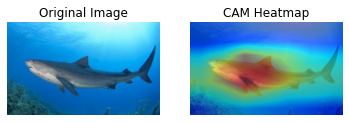

In [ ]:

image= Image.open('example.jpg')

# load the ResNet18 model
resnet18 = models.resnet152(pretrained=True)

# calculate the CAM
target_layer = 'layer4'
cam = calculate_cam(resnet18, target_layer, image)

# plot the original image and the CAM heatmap
plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(image)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('CAM Heatmap')

plt.show()
